
# EDA · Saber 11 (2017) — Nariño y Pasto · **TFM Data Science**

Este cuaderno desarrolla un **Análisis Exploratorio de Datos (EDA)** profesional sobre la cohorte **Saber 11 – 2016**, con foco en **Nariño** (y corte específico **Pasto**).  
El EDA está **alineado a los objetivos del TFM**: construir una base confiable de entrada para estimar, más adelante, el **Valor Agregado (VA)** y la **Contribución Relativa (CR)** del programa **Ingeniería de Sistemas – Universidad Mariana** al comparar **Saber 11 (entrada)** vs **Saber Pro (salida)**.

### Qué persigue este EDA
- **Calidad de datos**: unificar 2017_1 + 2017_2, limpiar tipos, normalizar textos, validar rangos y duplicados.
- **Caracterización de entrada** (baseline): puntajes globales y por áreas en Nariño / Pasto.
- **Contexto sociodemográfico**: género, estrato, naturaleza del colegio y jornada.
- **Estructuras agregadas** listas para VA/CR**: resúmenes por colegio y municipio exportados como insumo para el modelado.
- **Gráficas explicativas**: cada figura responde a una pregunta de negocio del TFM (ver notas bajo cada gráfico).

> **Nota**: Este cuaderno **no** calcula VA ni CR. Deja listos los **features** de entrada (Saber 11) que luego se cruzarán con **Saber Pro** por cohorte.


In [12]:

import os
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (9, 5),
    "axes.grid": True
})

print("Libs OK")

Libs OK



## 1) Lectura y unión de fuentes

Archivos oficiales ICFES (TXT `;`) de **2017**: primer y segundo semestre.  
**Edite las rutas si cambian los nombres.**


In [11]:

FILE_2016_1 = "Examen_Saber_11_20171.txt"
FILE_2016_2 = "Examen_Saber_11_20172.txt"

# Columnas de interés (tolerante: si falta alguna, el lector no falla)
COLS = [
    # Ubicación y colegio
    "cole_cod_depto_ubicacion","cole_cod_mcpio_ubicacion",
    "cole_depto_ubicacion","cole_mcpio_ubicacion",
    "cole_nombre_establecimiento","cole_naturaleza","cole_area_ubicacion","cole_jornada","cole_genero",
    # Estudiante / familia
    "estu_genero","estu_inse_individual","fami_estratovivienda",
    # Puntajes
    "punt_global","punt_matematicas","punt_lectura_critica",
    "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles",
    # Meta
    "periodo"
]

def safe_read(path, cols):
    if not os.path.exists(path):
        print(f"⚠️ No se encontró: {path}")
        return pd.DataFrame(columns=cols)
    df = pd.read_csv(path, sep=";", encoding="latin1", low_memory=False)
    keep = [c for c in cols if c in df.columns]
    return df[keep].copy()

df1 = safe_read(FILE_2016_1, COLS)
df2 = safe_read(FILE_2016_2, COLS)
df = pd.concat([df1, df2], ignore_index=True)
print("Dimensiones combinadas:", df.shape)
df.head(3)

Dimensiones combinadas: (676145, 19)


,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_depto_ubicacion,cole_mcpio_ubicacion,cole_nombre_establecimiento,cole_naturaleza,cole_area_ubicacion,cole_jornada,cole_genero,estu_genero,estu_inse_individual,fami_estratovivienda,punt_global,punt_matematicas,punt_lectura_critica,punt_sociales_ciudadanas,punt_c_naturales,punt_ingles,periodo
0,66.0,66001.0,RISARALDA,PEREIRA,COL FUNDACION LIC INGLES,NO OFICIAL,RURAL,COMPLETA,MIXTO,M,74.582306,Estrato 5,419,78,73,80,100,97,20171
1,8.0,8141.0,ATLANTICO,CANDELARIA,INSTITUCION EDUCATIVA CARRETO,OFICIAL,RURAL,MAÃANA,MIXTO,F,NaN,Estrato 1,195,42,34,40,41,37,20171
2,8.0,8141.0,ATLANTICO,CANDELARIA,INSTITUCION EDUCATIVA CARRETO,OFICIAL,RURAL,MAÃANA,MIXTO,M,NaN,Estrato 1,249,36,54,53,56,51,20171



## 2) Limpieza / Normalización

- Tipos numéricos para puntajes y códigos de ubicación.  
- Normalización robusta de textos (quita tildes/espacios no rompibles, mayúsculas).  
- Eliminación de duplicados.


In [13]:

# 2.1 Puntajes a numéricos
punt_cols = ["punt_global","punt_matematicas","punt_lectura_critica",
             "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles"]
for c in punt_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 2.2 Códigos a enteros (si existen)
for c in ["cole_cod_depto_ubicacion","cole_cod_mcpio_ubicacion"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

# 2.3 Normalizador de texto
def norm_text(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace("\xa0"," ", regex=False).str.strip()
    s = s.apply(lambda x: "".join(ch for ch in unicodedata.normalize("NFKD", x) if not unicodedata.combining(ch)))
    return s.str.upper()

for c in ["cole_depto_ubicacion","cole_mcpio_ubicacion","cole_nombre_establecimiento","cole_naturaleza",
          "cole_area_ubicacion","cole_jornada","cole_genero","estu_genero","fami_estratovivienda"]:
    if c in df.columns:
        df[c] = norm_text(df[c])

# 2.4 Duplicados
before = len(df)
df = df.drop_duplicates()
print("Duplicados eliminados:", before - len(df))

df.info()

Duplicados eliminados: 191
<class 'pandas.core.frame.DataFrame'>
Index: 675954 entries, 0 to 676144
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   cole_cod_depto_ubicacion     572273 non-null  Int64  
 1   cole_cod_mcpio_ubicacion     572273 non-null  Int64  
 2   cole_depto_ubicacion         675954 non-null  object 
 3   cole_mcpio_ubicacion         675954 non-null  object 
 4   cole_nombre_establecimiento  675954 non-null  object 
 5   cole_naturaleza              675954 non-null  object 
 6   cole_area_ubicacion          675954 non-null  object 
 7   cole_jornada                 675954 non-null  object 
 8   cole_genero                  675954 non-null  object 
 9   estu_genero                  675954 non-null  object 
 10  estu_inse_individual         560030 non-null  float64
 11  fami_estratovivienda         675954 non-null  object 
 12  punt_global                  675954 


## 3) Enfoque regional: **Nariño** y **Pasto**

Se aplican filtros por **código** y, como respaldo, por **texto normalizado**.


In [14]:

mask_narino = (
    (("cole_cod_depto_ubicacion" in df.columns) & (df["cole_cod_depto_ubicacion"] == 52))
    | (("cole_depto_ubicacion" in df.columns) & (df["cole_depto_ubicacion"] == "NARINO"))
)

mask_pasto = mask_narino & (
    (("cole_cod_mcpio_ubicacion" in df.columns) & (df["cole_cod_mcpio_ubicacion"] == 52001))
    | (("cole_mcpio_ubicacion" in df.columns) & (df["cole_mcpio_ubicacion"] == "PASTO"))
)

df_narino = df[mask_narino].copy()
df_pasto  = df[mask_pasto].copy()

print("Nariño:", df_narino.shape, " | Pasto:", df_pasto.shape)
display(df_narino.head(3))

Nariño: (17089, 19)  | Pasto: (5214, 19)


,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_depto_ubicacion,cole_mcpio_ubicacion,cole_nombre_establecimiento,cole_naturaleza,cole_area_ubicacion,cole_jornada,cole_genero,estu_genero,estu_inse_individual,fami_estratovivienda,punt_global,punt_matematicas,punt_lectura_critica,punt_sociales_ciudadanas,punt_c_naturales,punt_ingles,periodo
58,52,52356,NARIAO,IPIALES,COLEGIO INSECOL S.A.S.,NO OFICIAL,URBANO,TARDE,MIXTO,M,NaN,NAN,155,26,34,31,34,27,20171
59,52,52356,NARIAO,IPIALES,COLEGIO INSECOL S.A.S.,NO OFICIAL,URBANO,TARDE,MIXTO,M,46.311401,ESTRATO 3,214,43,42,42,51,23,20171
61,52,52356,NARIAO,IPIALES,COLEGIO INSECOL S.A.S.,NO OFICIAL,URBANO,TARDE,MIXTO,M,48.566750,ESTRATO 1,255,56,52,51,51,33,20171



## 4) Chequeos de calidad

Sanity checks mínimos para garantizar confiabilidad del baseline:
- Porcentaje de nulos en puntajes.
- Rango plausible de puntajes (0–500 aprox.).


In [15]:

# 4.1 Nulos en puntajes (Nariño)
nulls = df_narino[punt_cols].isna().mean().sort_values(ascending=False).to_frame("pct_null")
print("Porcentaje de nulos (Nariño):")
display((nulls*100).round(2))

# 4.2 Rango plausible
rmin = df_narino[punt_cols].min()
rmax = df_narino[punt_cols].max()
rng = pd.DataFrame({"min": rmin, "max": rmax})
print("Rango de puntajes observado (Nariño):")
display(rng)

Porcentaje de nulos (Nariño):


,pct_null
punt_global,0.0
punt_matematicas,0.0
punt_lectura_critica,0.0
punt_sociales_ciudadanas,0.0
punt_c_naturales,0.0
punt_ingles,0.0


Rango de puntajes observado (Nariño):


,min,max
punt_global,36,447
punt_matematicas,0,100
punt_lectura_critica,0,84
punt_sociales_ciudadanas,0,100
punt_c_naturales,0,100
punt_ingles,0,100



## 5) Descriptivos estadísticos (baseline de entrada)

Medidas de tendencia central y dispersión en **Nariño** y **Pasto**.


In [16]:

desc_narino = df_narino[punt_cols].describe().T
desc_pasto  = df_pasto[punt_cols].describe().T

print("Descriptivos — Nariño")
display(desc_narino)
print("Descriptivos — Pasto")
display(desc_pasto)

Descriptivos — Nariño


,count,mean,std,min,25%,50%,75%,max
punt_global,17089.0,256.335772,49.834648,36.0,218.0,255.0,292.0,447.0
punt_matematicas,17089.0,50.512727,12.537564,0.0,41.0,50.0,59.0,100.0
punt_lectura_critica,17089.0,52.929955,10.049757,0.0,46.0,53.0,60.0,84.0
punt_sociales_ciudadanas,17089.0,50.269472,11.168227,0.0,42.0,50.0,58.0,100.0
punt_c_naturales,17089.0,52.061911,10.466524,0.0,44.0,52.0,60.0,100.0
punt_ingles,17089.0,49.050851,11.124637,0.0,41.0,48.0,56.0,100.0


Descriptivos — Pasto


,count,mean,std,min,25%,50%,75%,max
punt_global,5214.0,273.794591,47.933039,150.0,238.0,273.0,308.0,447.0
punt_matematicas,5214.0,54.199079,11.930447,20.0,45.0,54.0,63.0,100.0
punt_lectura_critica,5214.0,56.228807,9.489684,27.0,50.0,56.0,63.0,84.0
punt_sociales_ciudadanas,5214.0,53.795934,10.973530,20.0,46.0,54.0,61.0,100.0
punt_c_naturales,5214.0,55.405063,9.952761,26.0,48.0,56.0,62.0,100.0
punt_ingles,5214.0,52.890295,11.802009,0.0,45.0,52.0,60.0,100.0



## 6) Perfil sociodemográfico (para análisis causal posterior)

Estas distribuciones explican **heterogeneidad de entrada**. Serán controles en modelos de VA/CR (evitan sesgos por composición):
- **Género** (`estu_genero`)
- **Estrato** (`fami_estratovivienda`)
- **Naturaleza del colegio** (`cole_naturaleza`)
- **Jornada** (`cole_jornada`)


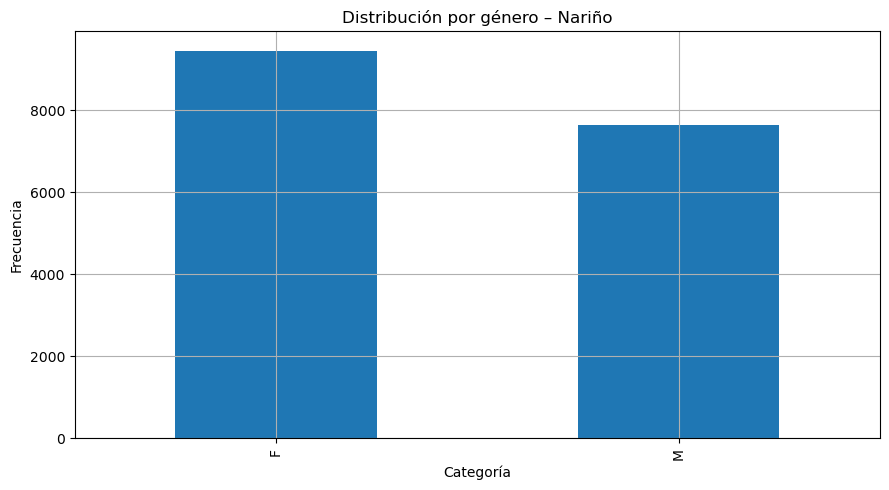

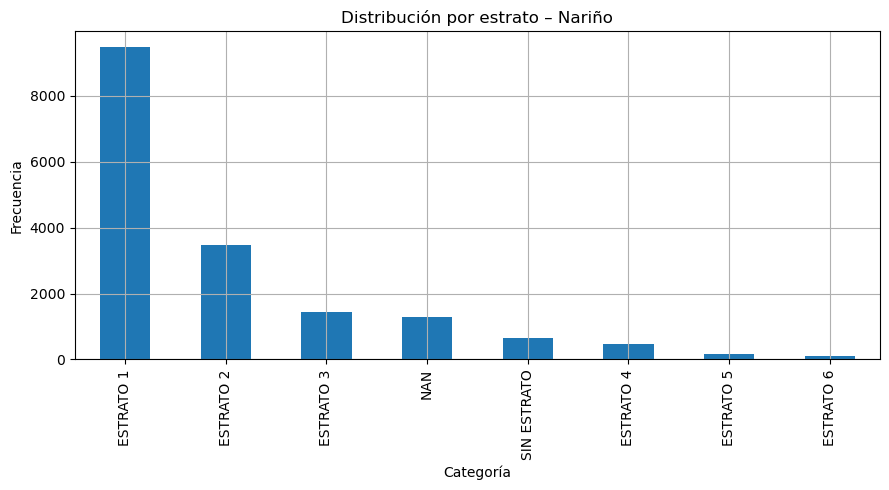

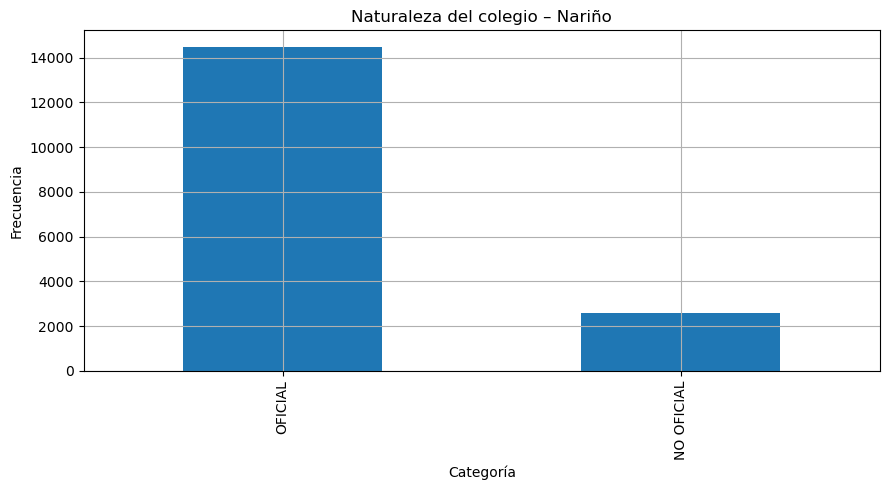

C:\Users\sebas\AppData\Local\Temp\ipykernel_7900\1283191449.py:8: UserWarning: Glyph 145 (\x91) missing from current font.
  plt.tight_layout()
c:\Users\sebas\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 145 (\x91) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


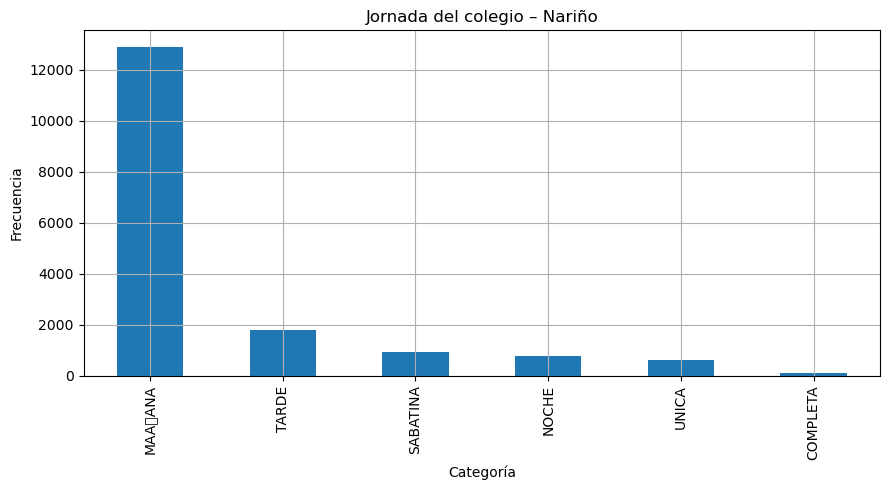

In [17]:

def bar_count(series, title):
    vc = series.value_counts(dropna=False)
    plt.figure()
    vc.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Categoría")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

if "estu_genero" in df_narino.columns:
    bar_count(df_narino["estu_genero"], "Distribución por género – Nariño")

if "fami_estratovivienda" in df_narino.columns:
    bar_count(df_narino["fami_estratovivienda"], "Distribución por estrato – Nariño")

if "cole_naturaleza" in df_narino.columns:
    bar_count(df_narino["cole_naturaleza"], "Naturaleza del colegio – Nariño")

if "cole_jornada" in df_narino.columns:
    bar_count(df_narino["cole_jornada"], "Jornada del colegio – Nariño")

1. Distribución por género – Nariño

Se evidencia una participación mayor de mujeres (aproximadamente 10.000) frente a hombres (cerca de 7.700). Esta diferencia de composición de género resulta significativa, pues podría incidir en los resultados globales y, por tanto, debe ser considerada como una variable de control al estimar el Valor Agregado (VA) y la Contribución Relativa (CR), evitando sesgos en la interpretación de los logros académicos.

2. Distribución por estrato – Nariño

La concentración mayoritaria de estudiantes en el estrato 1, seguida en menor medida por el estrato 2 y con una presencia casi marginal de estratos 3 a 6, refleja el contexto socioeconómico vulnerable de la región. Este factor estructural se constituye en una de las principales variables explicativas de los desempeños académicos y, en consecuencia, debe incorporarse en los modelos analíticos para aislar el efecto institucional de la Universidad frente a condiciones de origen.

3. Naturaleza del colegio – Nariño

Predominan los colegios oficiales sobre los no oficiales, lo cual ratifica la dependencia del sistema educativo público en el departamento. Esta diferencia cobra relevancia en el análisis, pues la naturaleza de la institución educativa previa condiciona las trayectorias académicas y los recursos disponibles, siendo indispensable ajustarla en los cálculos de VA y CR para obtener una estimación justa del aporte universitario.

4. Jornada del colegio – Nariño

La jornada de la mañana concentra la mayoría de estudiantes, con participación reducida de modalidades como tarde, nocturna, sabatina o completa. Esta homogeneidad indica que la variable jornada tiene un impacto limitado en la dispersión de resultados; no obstante, aporta información contextual para la caracterización integral de la población estudiantil.


**Uso en el TFM:** estas variables se incorporarán como **controles** al estimar el desempeño esperado en Saber Pro condicional a las características de entrada (baseline), permitiendo aislar el **efecto agregado** atribuible a la formación universitaria.



## 7) Distribución de puntajes (Nariño vs Pasto)

Las curvas y boxplots permiten visualizar **nivel y dispersión** de entrada por territorio.


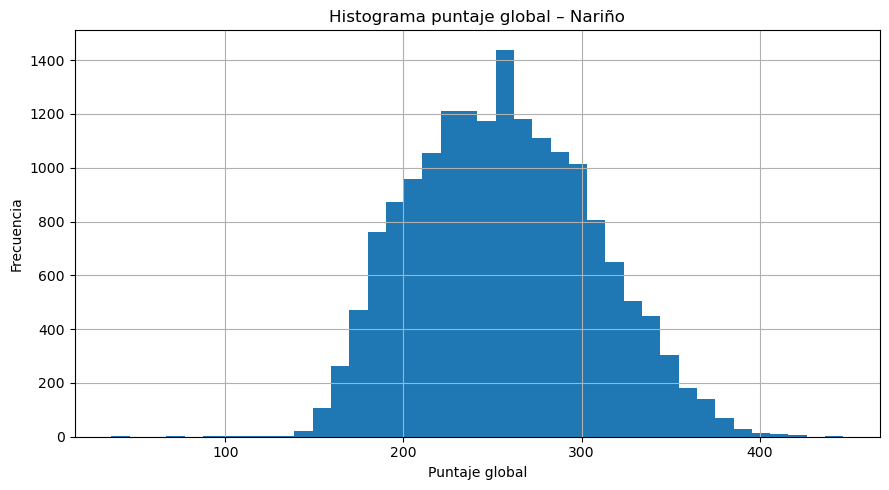

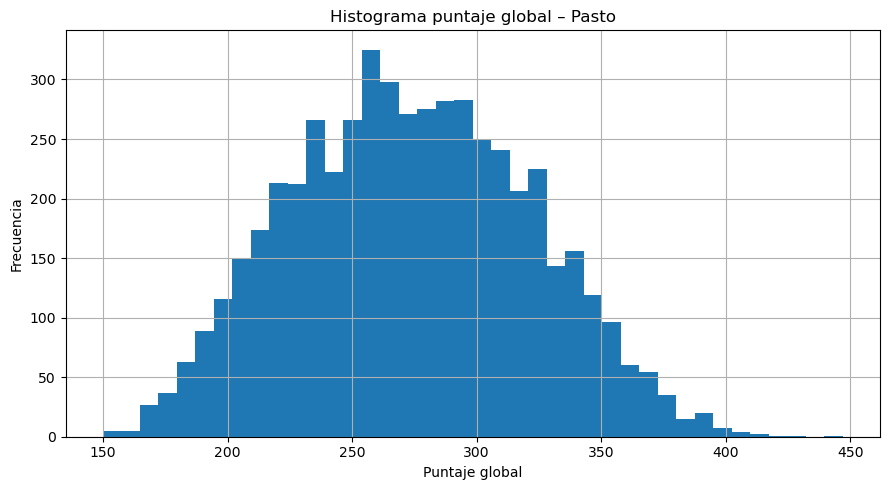

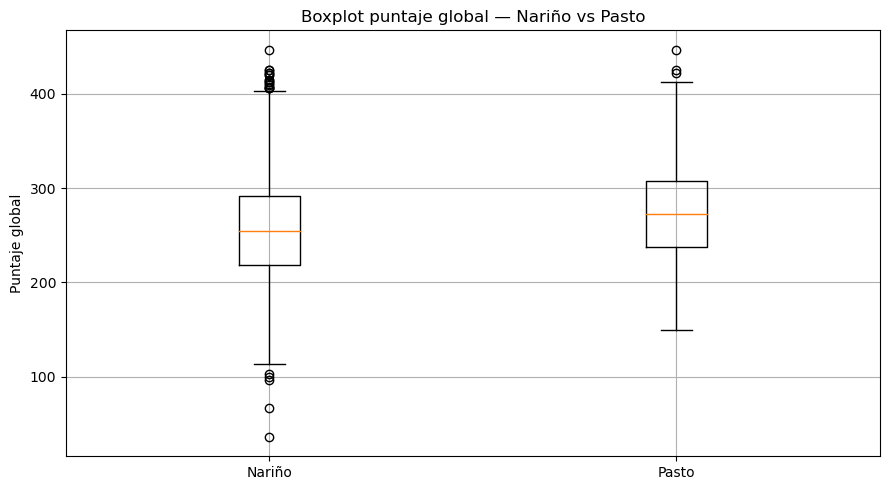

In [18]:

def hist_one(series, title, xlabel):
    if series.notna().any():
        plt.figure()
        series.dropna().plot(kind="hist", bins=40)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()

# Hist global
hist_one(df_narino["punt_global"], "Histograma puntaje global – Nariño", "Puntaje global")
hist_one(df_pasto["punt_global"],  "Histograma puntaje global – Pasto",  "Puntaje global")

# Boxplot comparativo
vals, labels = [], []
if df_narino["punt_global"].notna().any():
    vals.append(df_narino["punt_global"].dropna()); labels.append("Nariño")
if df_pasto["punt_global"].notna().any():
    vals.append(df_pasto["punt_global"].dropna());  labels.append("Pasto")

if vals:
    plt.figure()
    plt.boxplot(vals, labels=labels, vert=True)
    plt.title("Boxplot puntaje global — Nariño vs Pasto")
    plt.ylabel("Puntaje global")
    plt.tight_layout()
    plt.show()

5. Histograma de puntaje global – Nariño

La distribución de los puntajes globales presenta forma aproximadamente normal, con centro en los 250 puntos y pocos valores extremos. Este hallazgo sugiere un desempeño medio con dispersión moderada, que servirá como línea base para la estimación del VA, al permitir contrastar el nivel de entrada con los resultados posteriores de egreso universitario.

6. Histograma de puntaje global – Pasto

En la cabecera departamental, la distribución se desplaza hacia la derecha, con concentración más elevada entre los 260 y 300 puntos. Esto sugiere que los estudiantes de Pasto parten de un baseline más alto que el promedio de Nariño, lo cual debe ser controlado en los modelos de VA y CR para reconocer las diferencias de contexto urbano frente al resto del departamento.

7. Boxplot puntaje global – Nariño vs Pasto

El diagrama de caja confirma que Pasto presenta una mediana superior y menor dispersión interna en comparación con Nariño. Este hallazgo es central, ya que indica que los estudiantes de la capital ingresan con un nivel inicial más alto, lo que obliga a ajustar el cálculo del VA para evitar sobrestimar el aporte de la Universidad Mariana en comparación con poblaciones de base menos favorecida.


**Uso en el TFM:** estas figuras justifican los **ajustes de baseline** por territorio (municipio) cuando se calcule VA/CR, y permiten reportar si Pasto difiere sistemáticamente del resto del departamento.



## 8) Comparación por áreas (medias)

Promedios por competencia para Nariño vs Pasto. Útil para identificar **áreas deficitarias** de entrada.


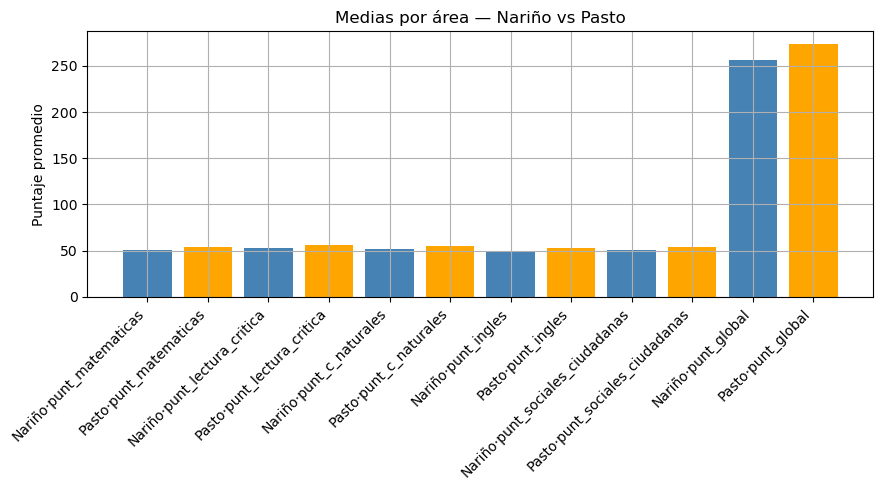

In [19]:
areas = ["punt_matematicas","punt_lectura_critica","punt_c_naturales",
         "punt_ingles","punt_sociales_ciudadanas","punt_global"]

means = []
labels = []
colors = []

for a in areas:
    if a in df_narino.columns:
        means.append(df_narino[a].mean())
        labels.append(f"Nariño·{a}")
        colors.append("steelblue")   # color para Nariño
    if a in df_pasto.columns:
        means.append(df_pasto[a].mean())
        labels.append(f"Pasto·{a}")
        colors.append("orange")      # color para Pasto

plt.figure()
plt.bar(labels, means, color=colors)
plt.title("Medias por área — Nariño vs Pasto")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Puntaje promedio")
plt.tight_layout()
plt.show()


8. Medias por área – Nariño vs Pasto

En todas las áreas evaluadas (matemáticas, lectura crítica, ciencias naturales, inglés y sociales ciudadanas), los estudiantes de Pasto superan ligeramente a los de Nariño. Las diferencias más marcadas aparecen en matemáticas e inglés, lo que señala competencias específicas donde el valor agregado del proceso universitario puede ser más visible y medible si se logra reducir la brecha o potenciar aún más dichos desempeños.



**Uso en el TFM:** orienta hipótesis de **valor agregado diferencial por competencias** (p. ej., si el baseline en matemáticas es bajo, esperar mayor VA si la universidad fortalece esta área).



## 9) Ranking de colegios (Pasto)

Se listan los **Top-10** por puntaje global promedio.  
Esto sirve para construir *perfiles de ingreso* por colegio en la futura plataforma web.


In [10]:

ranking_pasto = pd.DataFrame()
if {"cole_nombre_establecimiento","punt_global"}.issubset(df_pasto.columns):
    ranking_pasto = (df_pasto
                     .groupby("cole_nombre_establecimiento", as_index=False)["punt_global"]
                     .mean()
                     .sort_values("punt_global", ascending=False)
                     .head(10))
    display(ranking_pasto)
else:
    print("No hay columnas suficientes para el ranking.")

,cole_nombre_establecimiento,punt_global
67,LIC INTEGD DE BTO UNIVERSIDAD DE NARIAO,349.967391
14,COL SAN FRANCISCO JAVIER,335.074468
69,LICEO DE LA MERCED MARIDIAZ,321.234043
58,INST CHAMPAGNAT,317.021739
17,COLEGIO DEL SAGRADO CORAZON DE JESUS,313.702703
7,COL LA INMACULADA,313.620000
13,COL SAN FELIPE NERI,306.107143
53,I.E.M. SAN JOSE BETHLEMITAS,303.471698
5,COL FILIPENSE NUESTRA SRA DE LA ESPERANZA,303.301205
3,COL COMFAMILIAR DE NARIAO SIGLO XXI,302.854839



## 10) Exportación — **Features de entrada** para VA/CR

Se exportan datasets **limpios** y agregados que el pipeline utilizará al cruzar con Saber Pro:
- `s11_2016_narino.csv`, `s11_2016_pasto.csv` → registros individuales filtrados.
- `s11_2016_school_summary.csv` → promedio y tamaño por colegio (Nariño/Pasto).
- `s11_2016_muni_summary.csv` → promedio por municipio (Nariño).


In [20]:
from pathlib import Path
import pandas as pd

# Usa una ruta corta/sencilla (cámbiala si quieres)
out_dir = Path(r"C:\Temp\s11_2017_tfm_outputs")
out_dir.mkdir(parents=True, exist_ok=True)

punt_cols = ["punt_global","punt_matematicas","punt_lectura_critica",
             "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles"]

muni_summary = df_narino

out_file = out_dir / "s11_2017_muni_summary.csv"
muni_summary.to_csv(str(out_file), index=False, encoding="utf-8-sig")  # <-- str(...)
print("✅ Guardado:", out_file)


✅ Guardado: C:\Temp\s11_2017_tfm_outputs\s11_2017_muni_summary.csv


📌 Conclusión general:

Los resultados evidencian que la mayoría de estudiantes en Nariño pertenecen a contextos socioeconómicos bajos y asisten principalmente a colegios oficiales en jornada mañana. Aunque la distribución de puntajes es similar en forma, los estudiantes de Pasto alcanzan promedios más altos y una mediana superior en comparación con el total de Nariño, lo que sugiere una ventaja educativa en el entorno urbano frente al departamental.